Contrastive Vae

In [2]:
%reload_ext autoreload
%autoreload 2
from model import VAE, Encoder, Decoder
from train import train
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, sampler
from collections import defaultdict
from torch.autograd import Variable
from torch.nn import functional as F
from model import VAE
import torch.nn as nn
import cv2
import numpy as np
from PIL import Image 
from mnist import Net

Train the model (set to True for CVAE, False for VAE)

Epoch 00/10 Batch 0000/937, Loss  545.5496


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

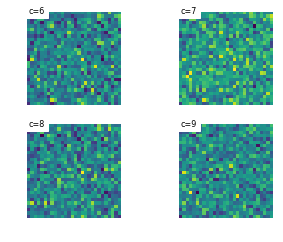

In [94]:
train(True)

Load VAE

/Users/lisadunlap/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'model.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/lisadunlap/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'model.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/lisadunlap/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'model.Decoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.M

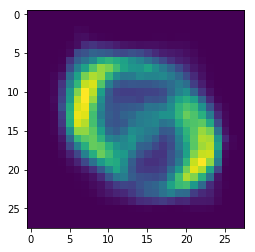

In [3]:
#load model and return a generated image of 3
vae = VAE(
        encoder_layer_sizes=[784, 256],
        latent_size=2,
        decoder_layer_sizes=[256, 784],
        conditional=False,
        num_labels=10 if False else 0)
vae = torch.load('figs/vae.pth')
c = torch.arange(0, 10).long().unsqueeze(1)
x=vae.inference(n=c.size(0), c=c)
plt.imshow(x[3].view(28, 28).data.numpy())

Load CVAE

/Users/lisadunlap/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'model.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/lisadunlap/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'model.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/lisadunlap/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'model.Decoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.M

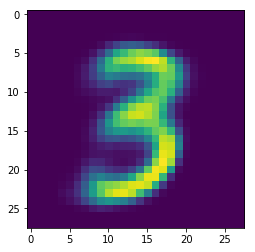

In [4]:
#load model and return a generated image of 3
vae = VAE(
        encoder_layer_sizes=[784, 256],
        latent_size=2,
        decoder_layer_sizes=[256, 784],
        conditional=True,
        num_labels=10 if True else 0)
vae = torch.load('figs/cvae.pth')
c = torch.arange(0, 10).long().unsqueeze(1)
x=vae.inference(n=c.size(0), c=c)
plt.imshow(x[3].view(28, 28).data.numpy())

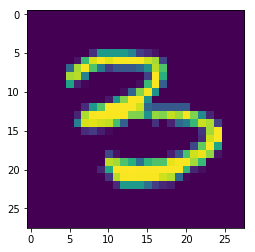

In [5]:
#Load MNIST dataset and create a DataLoader of 3s
dataset = MNIST(
        root='data', train=True, transform=transforms.ToTensor(),
        download=True)
data_loader = DataLoader(
    dataset=dataset, batch_size=1, shuffle=False)
threes = list()
index = 0
for (data, sample) in data_loader:
  if 3 == sample.data.numpy()[0]:
    threes.append(index)
  index = index+1
  
data_loader3 = DataLoader(
    dataset=dataset, batch_size=1, sampler = sampler.SubsetRandomSampler(threes))
data, sample = iter(data_loader3).next()
plt.imshow(data.view(28,28).data.numpy())

Generate an image given a 3 image and an 8 label

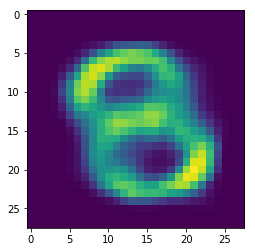

In [6]:
recon_x0, mean0, log_var0, z0 = vae(data, Variable(torch.tensor([[8]])))
plt.imshow(recon_x0.view(28, 28).data.numpy())
rec = recon_x0.view(28, 28).data.numpy()

Generate an image given both a 3 and an 8

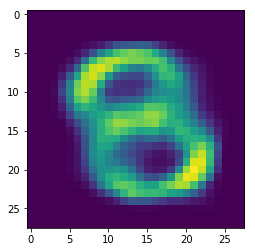

In [7]:
#vae(img, label, desired_label, alpha)
recon_x1, mean1, log_var1, z1 = vae(data, sample, Variable(torch.tensor([[8]])), .9)
plt.imshow(recon_x0.view(28, 28).data.numpy())
rec = recon_x0.view(28, 28).data.numpy()

In [8]:
model = Net().to("cpu")
model.load_state_dict(torch.load('models/mnist_cnn.pth'))

In [9]:
dataset = MNIST(
        root='data', train=True, transform=transforms.ToTensor(),
        download=True)
data_loader = DataLoader(
    dataset=dataset, batch_size=1, shuffle=False)

Finding Misclassified MNIST Images

In [10]:
dat2 = []
i=0
for (data, target) in data_loader:
    output = model.forward(data)
    sm = output[0].data.cpu().numpy()
    ans = target.data.cpu().numpy()[0]
    if sm.argmax(axis=0) != ans:
        dat2.append(i)
    i = i+1
data_loader3 = DataLoader(
    dataset=dataset, batch_size=1, sampler = sampler.SubsetRandomSampler(dat2))

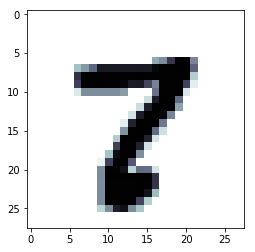

In [17]:
data, sample = iter(data_loader3).next()
plt.imshow(data.view(28,28).data.numpy()*-1, plt.bone())

In [12]:
truth = int(sample.data.cpu().numpy()[0])
print("real label: ", truth)
output = model(data)
sm = output[0].data.cpu().numpy()
label = int(sm.argmax(axis=0))
print("model label: ", label)

real label:  5
model label:  8


Alter the alpha until the model classifies it correctly

In [ ]:
alpha = 1
recon_x1, mean1, log_var1, z1 = vae(data, Variable(torch.tensor([[label]])), Variable(torch.tensor([[truth]])), alpha)
thing = Variable(torch.tensor([[recon_x1.view(28,28).data.numpy()]]))
output = model(thing)
sm = output[0].data.cpu().numpy()
while sm.argmax(axis=0) != sample.data.cpu().numpy()[0] or alpha <= 0:
    alpha = alpha - .01
    recon_x1, mean1, log_var1, z1 = vae(data, Variable(torch.tensor([[label]])), Variable(torch.tensor([[truth]])), alpha)
    thing = Variable(torch.tensor([[recon_x1.view(28,28).data.numpy()]]))
    output = model(thing)
    sm = output[0].data.cpu().numpy()
print(alpha)
plt.imshow(recon_x1.view(28, 28).data.numpy(), plt.bone())

Combine the two images

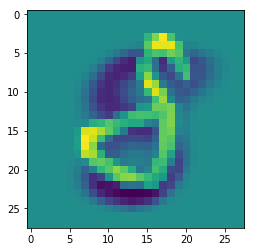

In [15]:
plt.imshow(data.view(28,28).data.numpy()-recon_x1.view(28, 28).data.numpy())